In [49]:
import numpy as np
import scipy as sp
import time, datetime
import os
import shutil
import joblib
from skimage.io import imread
import pandas as pd
from skimage import img_as_float
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import precision_score, accuracy_score, make_scorer, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

%matplotlib inline

# 0.1 Set of functions to fit an image with a gaussian

In [2]:
def gaus_moments(data):
    """Returns a dict containing initial guesses for 2D-Gaussian parameters: 
    (background, amplitude, x_mean, y_mean, sigma_x, sigma_y)
    
    Assuming that image is approximately centered"""
    total = data.sum()
    Y, X = np.indices(data.shape)
    x = data.shape[0]/2 #(X*data).sum()/total
    y = data.shape[1]/2 #(Y*data).sum()/total
    col = data[:, int(y)]
    sigma_y = np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum()
    row = data[int(x), :]
    sigma_x = np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum()
    height = data.min()
    amplitude = data.max() - height
    mom={'background':height, 'amplitude':amplitude, 'x_mean':x, 'y_mean':y, 'sigma_x':sigma_x, 'sigma_y':sigma_y}
    return mom

In [3]:
def twod_gaussian(height, amplitude, center_x, center_y, sig_x, sig_y, sig_xy):
    """Returns a gaussian function with the given parameters"""
    #Sigma = [[sig_x, sig_xy], [sig_xy, sig_y]]
    Sigmin= [[sig_y, -sig_xy], [-sig_xy, sig_x]]/(sig_x*sig_y - sig_xy**2 + 10**-4)
    center = np.array([center_x, center_y]).reshape((1,1,2))
    #print center.shape, Sigmin.shape, center.dot(Sigmin).shape
    return lambda x: height+ amplitude*np.exp(-( (x-center).dot(Sigmin)*(x-center) ).sum(axis=-1)/2)

In [4]:
def fit_gaussian(data):
    """Returns 2D-Gaussian fit parameters:
    (height, amplitude, center_x, center_y, sig_x, sig_y, sig_xy)
    found by a optimizing least squares of an error"""
    mome = gaus_moments(data)
    para = [mome['background'], mome['amplitude'], mome['x_mean'], mome['y_mean'], mome['sigma_x'], mome['sigma_y'], 1.2]
    x = np.stack(np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1])), axis=-1)
    errorfunction = lambda p: np.ravel(twod_gaussian(*p)(x) - data)
    p, success = sp.optimize.leastsq(errorfunction, para)
    #print success
    return p

## 0.2 Set of functions for processing the data

In [5]:
def load_imgs(dir_name='dust_fog', numb = 10):
    """
    Loading 'numb' of images from 'dir_name'
    and reshaping each one into 8 polarization images of shape 30x30
    -------
    Output:   numpy array of shape 'numb' x 8 x 30 x 30
    """
    dir_name = 'D:/NEWSdm/crops/'+dir_name
    img_arr = []
    num_i = 0
    for img_name in os.listdir(dir_name):
        num_i += 1
        if num_i > numb :
            break
        tmp_im = (pd.read_csv(os.path.join(dir_name, img_name), header=None).drop(30, axis=1)).values.reshape((8,30,30))
        img_arr.append(tmp_im)
    return np.array(img_arr)

In [6]:
def imgs_to_params(imgs):
    """
    Takes array (shape=[numb,8,30,30]) of numb x 8 images of shape 30 x 30
    and fits a 2D Gaussian on each of the images.
    -------
    Output: DataFrame with fitting parameters for images in the array.
    """
    params = pd.DataFrame(columns=['img_num', 'polar', 'height', 'amplitude', 'center_x', 'center_y', 'sig_x', 'sig_y', 'sig_xy'])
    for num in xrange(imgs.shape[0]):
        i=0
        for data in imgs[num]:
            par = np.concatenate(([num+1, i], fit_gaussian(data)))
            par = par.reshape((1,len(par)))
            i += 1
            params = params.append(pd.DataFrame(par,columns=['img_num', 'polar', 'height', 'amplitude', 'center_x', 'center_y', 'sig_x', 'sig_y', 'sig_xy']), ignore_index=True)
    return params

In [7]:
def clean_params(params, up_bound=500):
    """
    Dropping divergent samples (rows) from the dataset.
    Sample is divergent if any parameter (except 'sig_xy') is negative or larger than 'up_bound'
    """
    img_num = params.get('img_num')
    cov_xy = params.get('sig_xy')
    params = params.drop(['img_num','sig_xy'],axis=1)
    params = params[params[params<up_bound]>=0]
    params = pd.concat([img_num, params, cov_xy], axis=1, join='inner')
    return params.dropna()

In [8]:
def params_to_features(params):
    """
    Getting physical features from fitting parameters:
    polarization number, amplitude, center position, rotation (represented by 'sig_xy'), minor axis, eccentrisity, area
    -------
    Output: DataFrame with features for every image
    """
    Sigms = params.get(['sig_x','sig_y','sig_xy']).values
    idx = params.index
    #print Sigms.shape
    a_ar = []
    area_ar = []
    eps_ar = []
    for s in Sigms:
        #print s
        a, b = np.linalg.eigvalsh([[s[0],s[2]],[s[2],s[1]]])
        if a>b:
            tmp = a
            a = b
            b = tmp
        a_ar.append(a)
        area_ar.append(np.pi * a * b)
        eps = b/a
        if eps<1: eps = 1/eps
        eps_ar.append(eps)
    ellip_par = pd.DataFrame(data={'minor_ax':a_ar, 'eps':eps_ar, 'area':area_ar}, index=idx)
    #print ellip_par.shape
    feat = params.drop(['img_num','height','sig_x','sig_y'],axis=1)
    feat = pd.concat([feat, ellip_par], axis=1)
    return feat

In [9]:
def feat_to_input(ft_data, cl_names):
    """
    Stacking data with names from 'cl_names' into one DataFrame labeling 'signal' with 1 and 'noise' with 0.
    """
    inp_data = pd.DataFrame(columns=np.concatenate((['target'], ft_data[cl_names[0]].columns.values)) )
    for name in cl_names:
        idx = ft_data[name].index
        if name[0] == 'C' :
            targ = pd.DataFrame(data={'target':np.ones(len(idx))}, index=idx)
        else: targ = pd.DataFrame(data={'target': np.zeros(len(idx))}, index=idx)
        app_data = pd.concat([targ, ft_data[name]], axis=1)
        inp_data = inp_data.append(app_data, ignore_index=True)
    return inp_data    

In [10]:
# should be improved

def load_and_fit_batches(class_name='dust_fog', numb = 10000, node=1, n_cpu=1, n_0 = 1000):
    """
    Loading 'numb' of samples in total from 'class_name' and fitting them with Gaussians and writing results files.
    1. Taking 'n_0' samples at a time and rewriting the same variables on each iteration.
    2. Pseudo-parallelised by running 'n_cpu' applications at once by hands with different 'node' numbers.
    -------
    Output:
    Written 'csv' files with fitting parameters in specific folders, returns 'nump' totall number of samples processed.
    The resulting files are like 'D:/NEWSdm/crops/csvs/batches/50000/gamma/cpu3_n1_it1_params.csv'
    
    *Important*: 'numb' must be devidible by 'n_0', otherwise up to 'n_0' extra samples wil be processe.
    """
    #Getting the number of iterations on this node.
    i_m = np.int(float(numb)/(n_0 * n_cpu))
    over = np.ceil((float(numb) - i_m*n_0*n_cpu)/n_0)
    if node <= over:
        i_m +=1 # each node has it's own i_m
        
    
    dir_name = 'D:/NEWSdm/crops/'+class_name
    nump = 0
    img_names = os.listdir(dir_name)
    for i in range(i_m):
        #iterating over samples in the batch
        img_arr = []
        for img_name in img_names[(node+i-1)*n_0 : (node+i)*n_0]:
            tmp_im = (pd.read_csv(os.path.join(dir_name, img_name), header=None).drop(30, axis=1)).values.reshape((8,30,30))
            img_arr.append(tmp_im)
        img_arr = np.array(img_arr)
        #getting parametrs of samples in the batch and writing tham to file.
        params = pd.DataFrame(columns=['img_num', 'polar', 'height', 'amplitude', 'center_x', 'center_y', 'sig_x', 'sig_y', 'sig_xy'])
        for img_num in np.arange(img_arr.shape[0]):
            polar=1
            for data in img_arr[img_num]:
                par = np.concatenate(([img_num+1, polar], fit_gaussian(data)))
                par = par.reshape((1,len(par)))
                polar += 1
                nump += 1
                params = params.append(pd.DataFrame(par,columns=['img_num', 'polar', 'height', 'amplitude', 'center_x', 'center_y', 'sig_x', 'sig_y', 'sig_xy']), ignore_index=True)
        output_name = str(numb)+'/'+class_name+'/cpu'+str(n_cpu)+'_n'+str(node)+'_it'+str(i+1)+'_params'
        params.to_csv('D:/NEWSdm/crops/csvs/batches/'+output_name+'.csv')
    '''
    Пофиксить что самая последняя итерация выбегает за пределы, если не делится нацело. Или делить нацело :)
    '''
    return nump

In [11]:
def read_params_from_names(numb, name):
    """
    Reading and stacking DataFrames with parameters from the specified directory: 
    D:/NEWSdm/crops/csvs/batches/'numb'/name
    """
    dir_name = 'D:/NEWSdm/crops/csvs/batches/'+str(numb)+'/'+name
    params = pd.DataFrame(columns=['img_num', 'polar', 'height', 'amplitude', 'center_x', 'center_y', 'sig_x', 'sig_y', 'sig_xy'])
    for img_name in os.listdir(dir_name):
        par = pd.read_csv(os.path.join(dir_name, img_name), index_col=0)
        params = params.append(par, ignore_index=True)
    return params

In [12]:
def clean_quantile_feat(params, quant_up, quant_down):
    """
    Dropping few percent most outlying samples using quantiles, which are bigger than quant_up or smaller than quant_down.
    """
    polar = params.get('polar')
    params = params.drop(['polar'],axis=1)
    for key in params.keys():
        params = params[ params[key]<params[key].quantile(quant_up[key]) ]
        params = params[ params[key]>params[key].quantile(1-quant_down[key]) ]
    params = pd.concat([polar, params], axis=1, join='inner')
    return params.dropna()

In [13]:
class_names = ['C60keV','C80keV','C100keV','dust_fog','gamma']

In [14]:
feat_names = ['polar', 'amplitude', 'center_x', 'center_y', 'sig_xy', 'area', 'eps', 'minor_ax']

## 1. Training on 20k samples of each type

In [15]:
repeated = False

##### 1.1 Fitting the images and saving parameters into files
* _repeated_ is for recreating the output directory if you are running the same number of samples not for the first time
* 20000 images on two nodes ~14hours

```
%%time
numb = 20000
if repeated:
    shutil.rmtree('D:/NEWSdm/crops/csvs/batches/'+str(numb)+'/')
os.mkdir('D:/NEWSdm/crops/csvs/batches/'+str(numb)+'/')
giant_data_numb = {}
for name in class_names:
    os.mkdir('D:/NEWSdm/crops/csvs/batches/'+str(numb)+'/'+name+'/')
    repeated = True
    giant_data_numb[name] = load_and_fit_batches(class_name=name, numb=numb, node=1, n_cpu=2)
```

##### 1.2 Loading files with Gaussian parameters and transforming them to input features

In [16]:
%%time
##### Loading previosly saved parameters
numb = 20000

giant_data_params = {}
for name in class_names:
    giant_data_params[name] = read_params_from_names(numb, name)


##### Droping the samples where fit diverges

cleaned_giant_data = {}
for name in class_names:
    cleaned_giant_data[name] = clean_params(giant_data_params[name])


print 'cleaned data shape'

for (key,value) in cleaned_giant_data.iteritems():
    print key,'  \t', value.shape

##### Transforming fitting parameters into physical features of the image

feat_giant_data = {}
for name in class_names:
    feat_giant_data[name] = params_to_features(cleaned_giant_data[name])
    
##### Merging all data into one DataFrame with appropriate target labels (signal/noise)

input_giant_data = feat_to_input(feat_giant_data, class_names)

print input_giant_data.shape, '\n\n', input_giant_data.head(1)

#### Spliting data into train and test
# * Precision is the scorer

X_giant = input_giant_data.drop(['target'], axis=1).values
y_giant = input_giant_data.get('target').values
X_giant_train_raw, X_giant_test_raw, y_giant_train, y_giant_test = train_test_split(X_giant, y_giant, test_size=0.1, stratify=y_giant)
scaler = StandardScaler()
X_giant_train_scaled = scaler.fit_transform(X_giant_train_raw)
X_giant_test_scaled = scaler.transform(X_giant_test_raw)

prec_scorer = make_scorer(precision_score)

cleaned data shape
C80keV   	(103013, 9)
C60keV   	(131833, 9)
C100keV   	(147079, 9)
gamma   	(145447, 9)
dust_fog   	(120861, 9)
(648233, 9) 

   target  polar  amplitude   center_x   center_y    sig_xy       area  \
0     1.0    1.0   5.108879  14.329652  14.817351  0.001597  87.683335   

        eps  minor_ax  
0  1.844835  3.889599  
Wall time: 1min 1s


## 2. Playing around with data

In [17]:
clean_giant_feat = {}

Removing 'polar' from features list, because it has small importance.

In [18]:
feat_names.remove('polar')

##### 2.0 Showing that data has small amount of very outlying samples

In [19]:
copa_data = feat_giant_data['C100keV']
copa_data.quantile(0.99)

polar            8.000000
amplitude      275.061352
center_x        26.919330
center_y        24.881140
sig_xy          46.205229
area         92829.851586
eps             10.890792
minor_ax       103.446898
Name: 0.99, dtype: float64

In [20]:
copa_data.max()

polar        8.000000e+00
amplitude    4.967720e+02
center_x     5.219505e+01
center_y     6.494906e+01
sig_xy       3.635248e+02
area         6.116837e+05
eps          3.956665e+09
minor_ax     3.819096e+02
dtype: float64

##### 2.1 Plotting distributions without cleaning data

In [21]:
features_raw = {}
for feat in feat_names:
    features_raw[feat] = pd.DataFrame(columns=[], index=[0])
    for name in class_names:
        conc_feat = pd.Series(feat_giant_data[name][feat].values, name=name, index=range(feat_giant_data[name].shape[0]))
        features_raw[feat] =  pd.concat([features_raw[feat], conc_feat], axis=1, ignore_index=False)

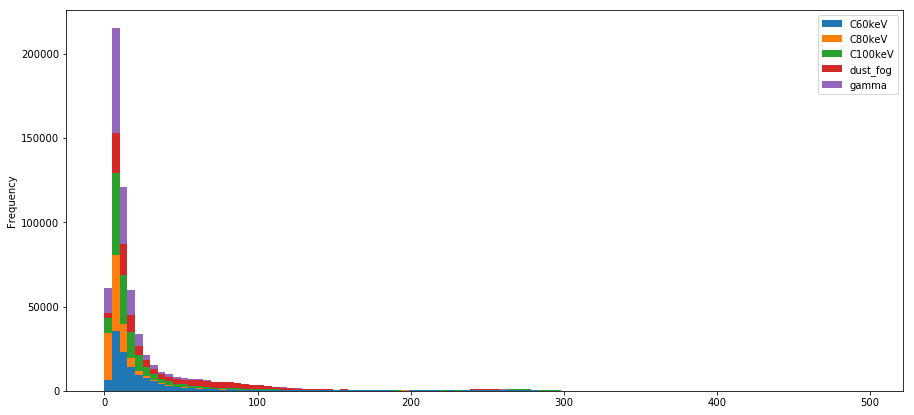

In [22]:
features_raw['amplitude'].plot.hist(stacked=True, bins=100, figsize=(15,7))

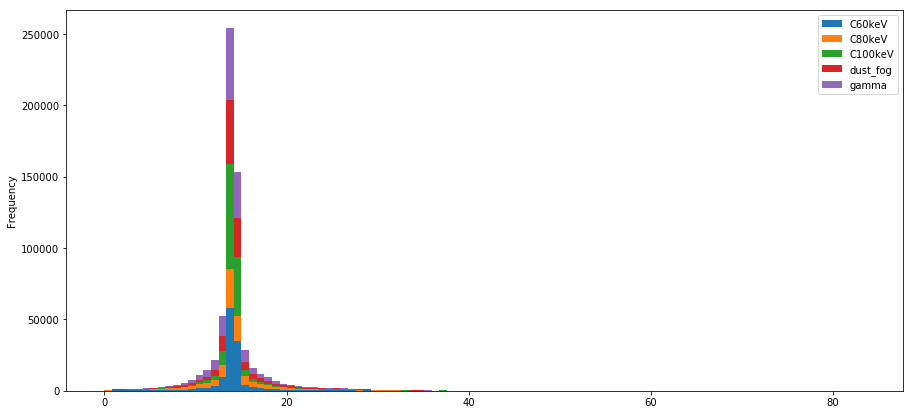

In [23]:
features_raw['center_x'].plot.hist(stacked=True, bins=100, figsize=(15,7))

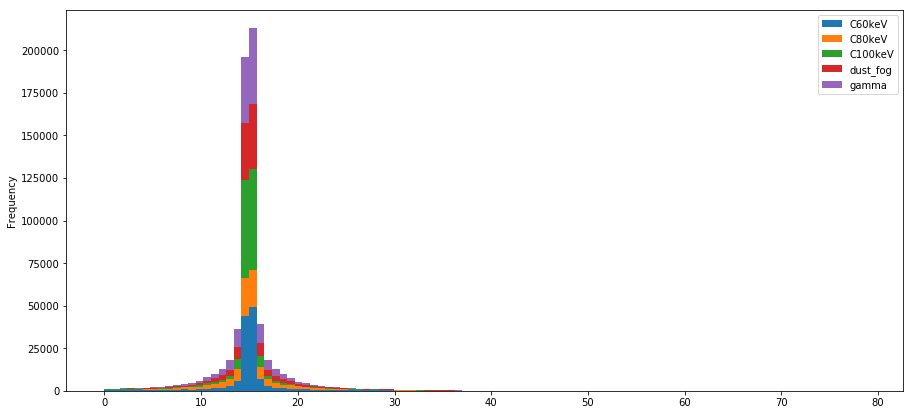

In [24]:
features_raw['center_y'].plot.hist(stacked=True, bins=100, figsize=(15,7))

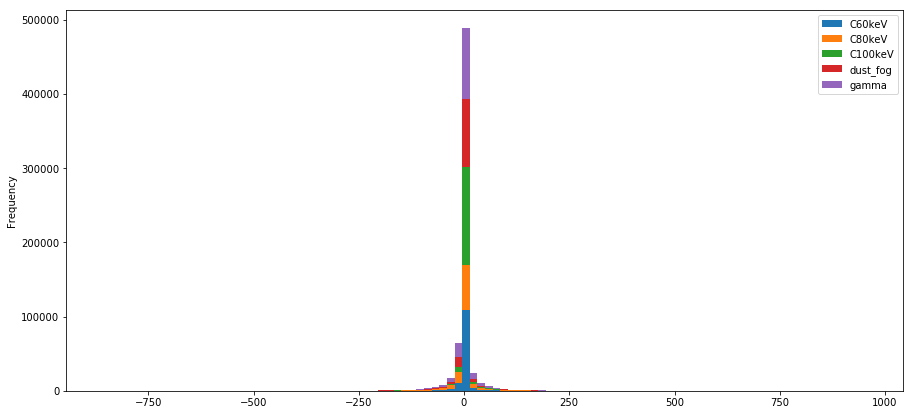

In [25]:
features_raw['sig_xy'].plot.hist(stacked=True, bins=100, figsize=(15,7))

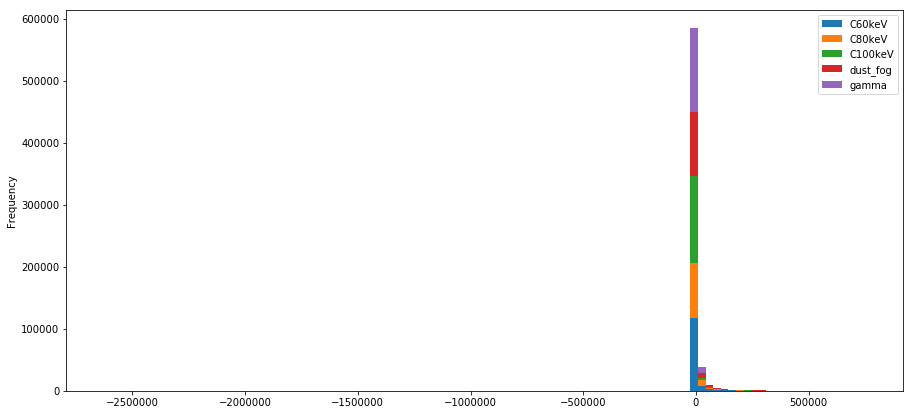

In [26]:
features_raw['area'].plot.hist(stacked=True, bins=100, figsize=(15,7))

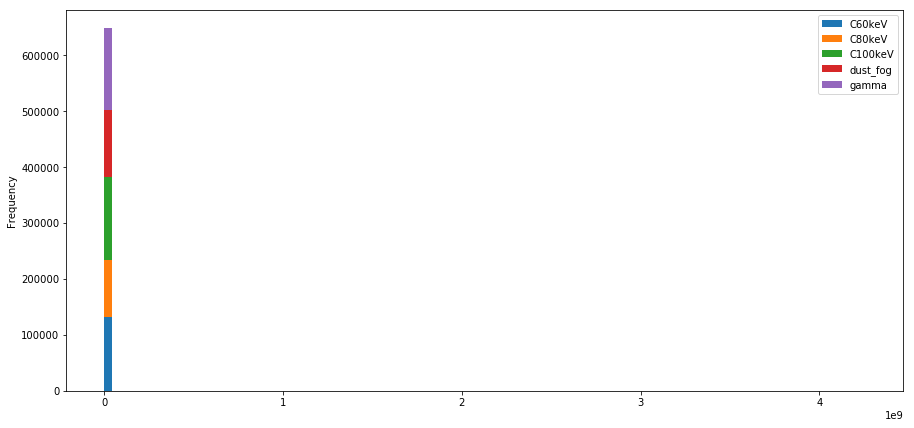

In [27]:
features_raw['eps'].plot.hist(stacked=True, bins=100, figsize=(15,7))

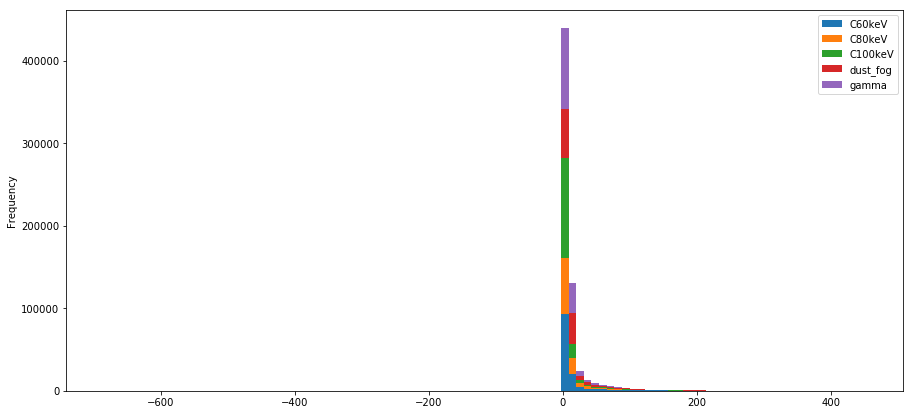

In [28]:
features_raw['minor_ax'].plot.hist(stacked=True, bins=100, figsize=(15,7))

Not informative at all without cleaning.

##### 2.2 Cleaning data discarding small part of the most divergent results

In [29]:
feat_giant_data['C100keV'].head(0)

Empty DataFrame
Columns: [polar, amplitude, center_x, center_y, sig_xy, area, eps, minor_ax]
Index: []

In [30]:
quant = {}
quant['amplitude'] = 0.96
quant['center_x'] = 0.98
quant['center_y'] = 0.98
quant['sig_xy'] = 0.98
quant['area'] = 0.965
quant['eps'] = 0.993
quant['minor_ax'] = 0.993

In [31]:
quant = {}
for feat in feat_names:
    quant[feat] = 0.97

In [32]:
for name in class_names:
    clean_giant_feat[name] = clean_quantile_feat(feat_giant_data[name], quant, quant)

##### 2.3 Plotting the cleared data distributions

In [33]:
features_clean = {}
for feat in feat_names:
    features_clean[feat] = pd.DataFrame(columns=[], index=[0])
    for name in class_names:
        conc_feat = pd.Series(clean_giant_feat[name][feat].values, name=name, index=range(clean_giant_feat[name].shape[0]))
        features_clean[feat] =  pd.concat([features_clean[feat], conc_feat], axis=1, ignore_index=False)

**2.3.1** Histogram approach

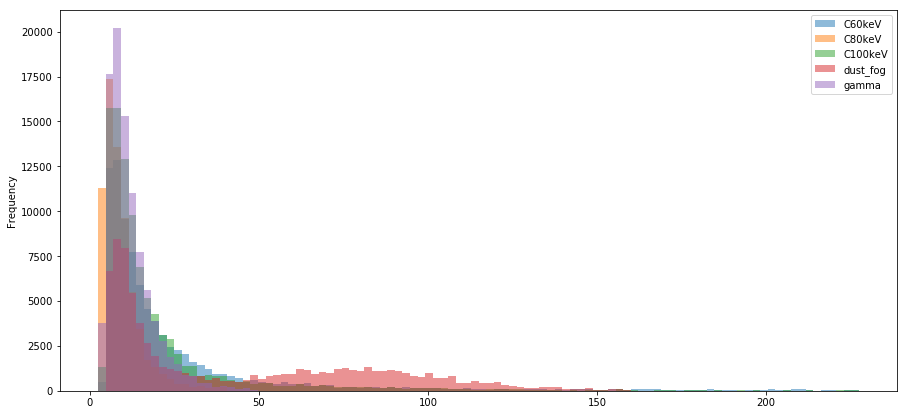

In [34]:
features_clean['amplitude'].plot.hist(bins=100, figsize=(15,7), alpha=0.5)

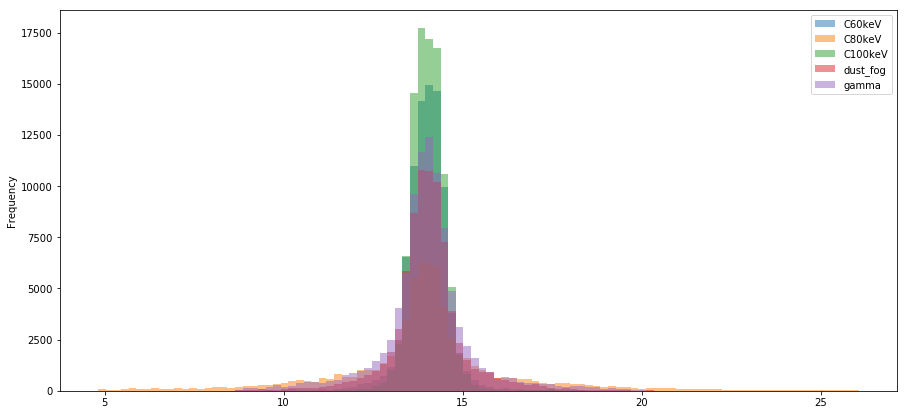

In [35]:
features_clean['center_x'].plot.hist(alpha=0.5, bins=100, figsize=(15,7))

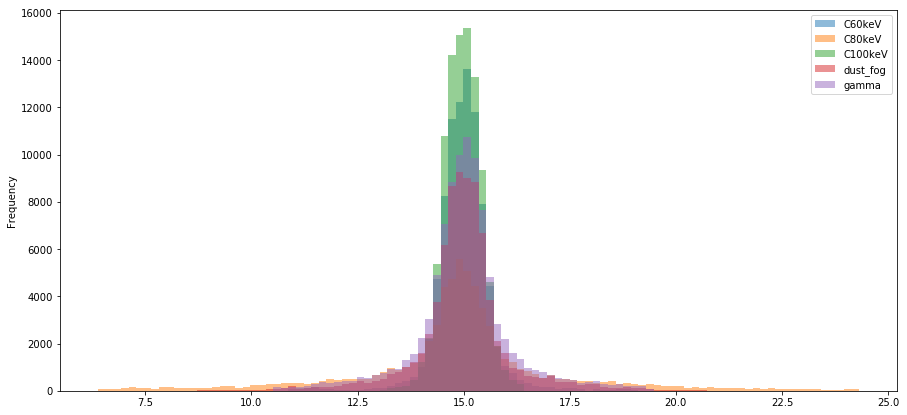

In [36]:
features_clean['center_y'].plot.hist(alpha=0.5, bins=100, figsize=(15,7))

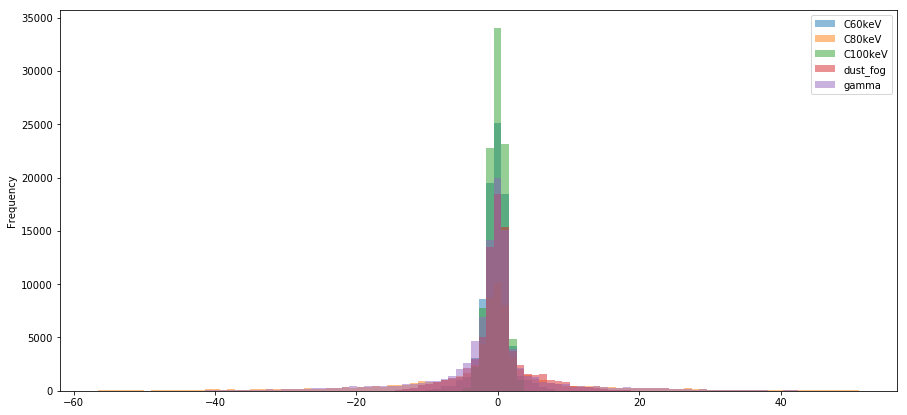

In [37]:
features_clean['sig_xy'].plot.hist(alpha=0.5, bins=100, figsize=(15,7))

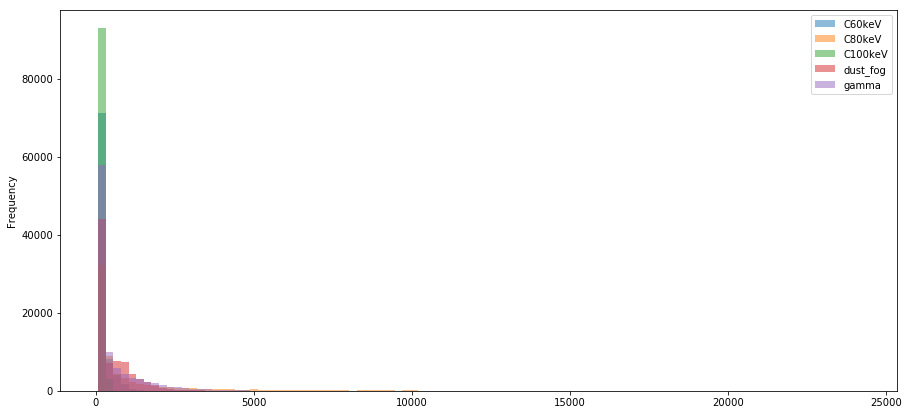

In [38]:
features_clean['area'].plot.hist(alpha=0.5, bins=100, figsize=(15,7))

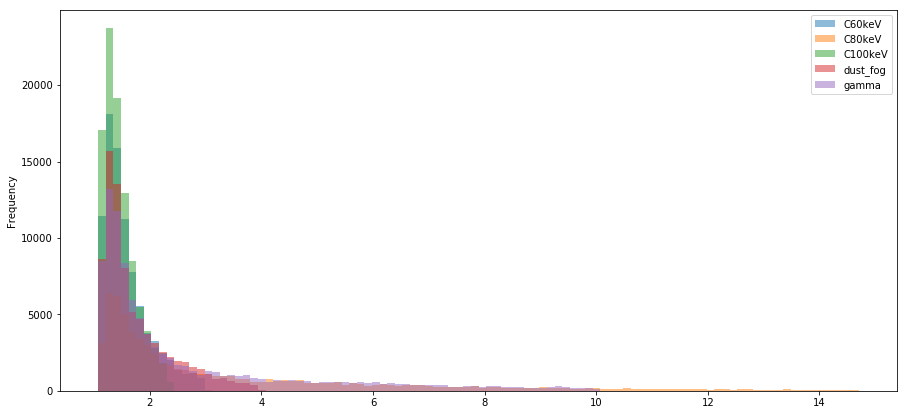

In [39]:
features_clean['eps'].plot.hist(alpha=0.5, bins=100, figsize=(15,7))

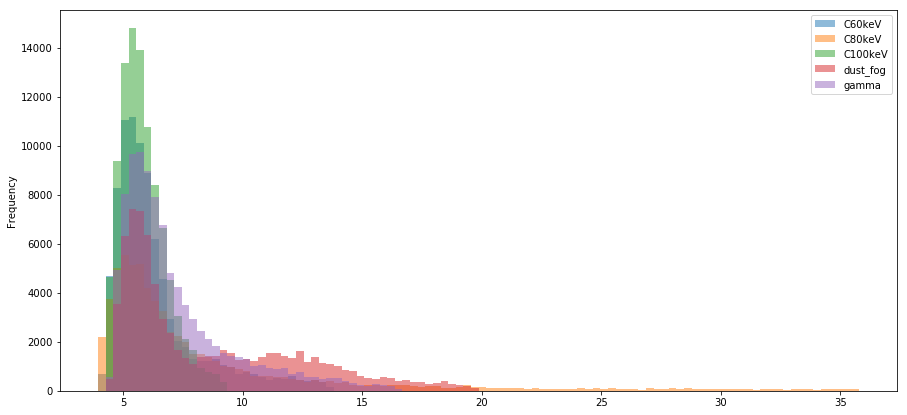

In [40]:
features_clean['minor_ax'].plot.hist(alpha=0.5, bins=100, figsize=(15,7))

**2.3.2** KDE approach

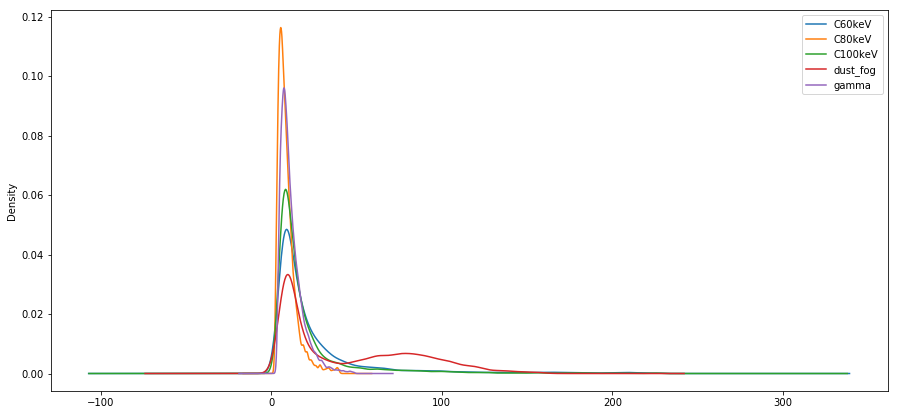

In [41]:
features_clean['amplitude'].plot.kde(stacked=True, figsize=(15,7))

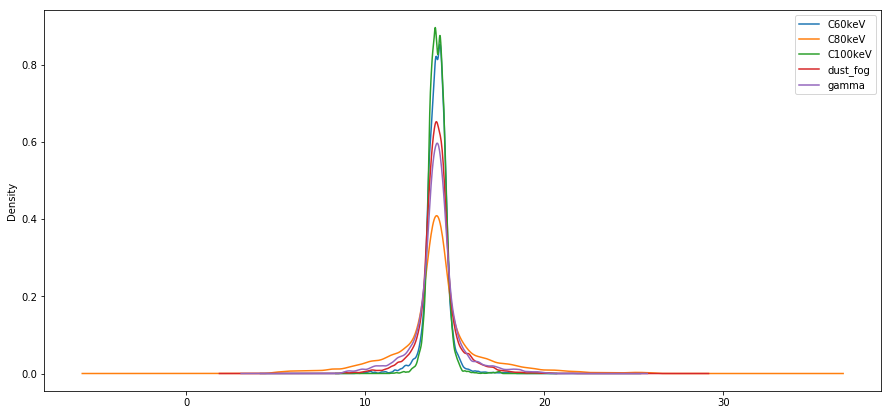

In [42]:
features_clean['center_x'].plot.kde(stacked=True, figsize=(15,7))

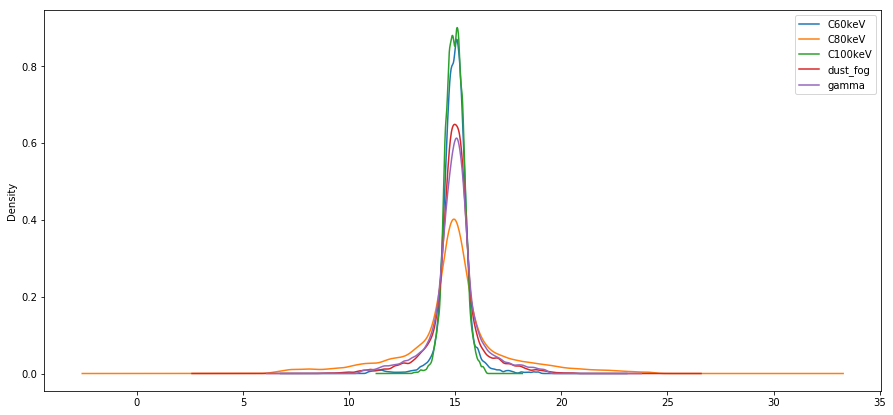

In [43]:
features_clean['center_y'].plot.kde(stacked=True, figsize=(15,7))

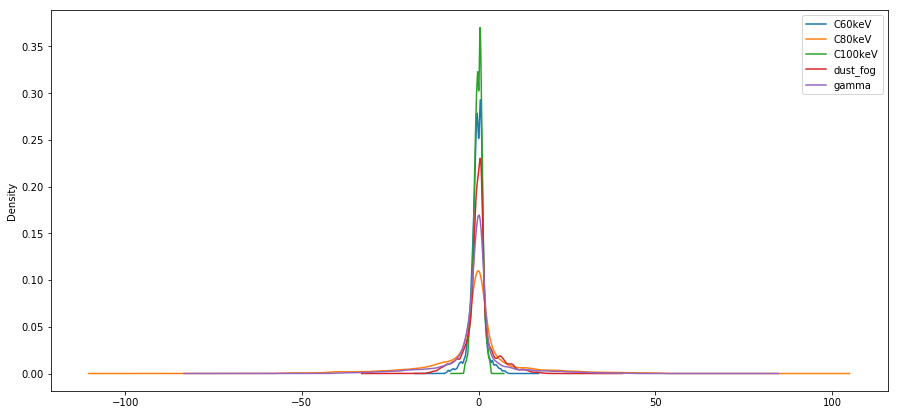

In [44]:
features_clean['sig_xy'].plot.kde(stacked=True, figsize=(15,7))

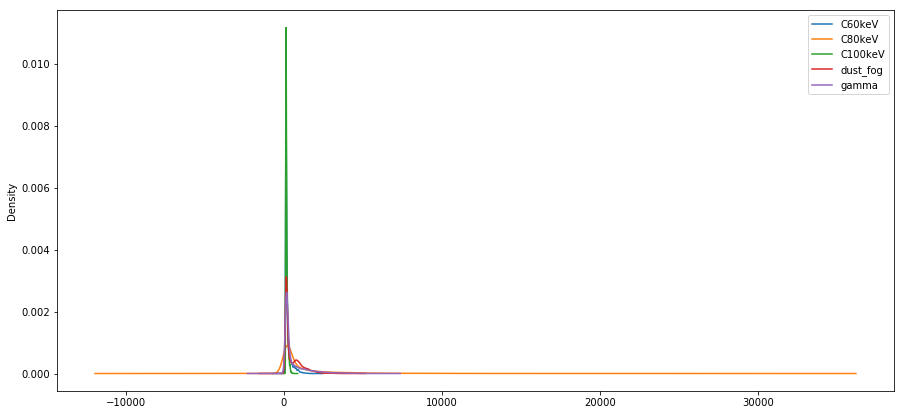

In [45]:
features_clean['area'].plot.kde(stacked=True, figsize=(15,7))

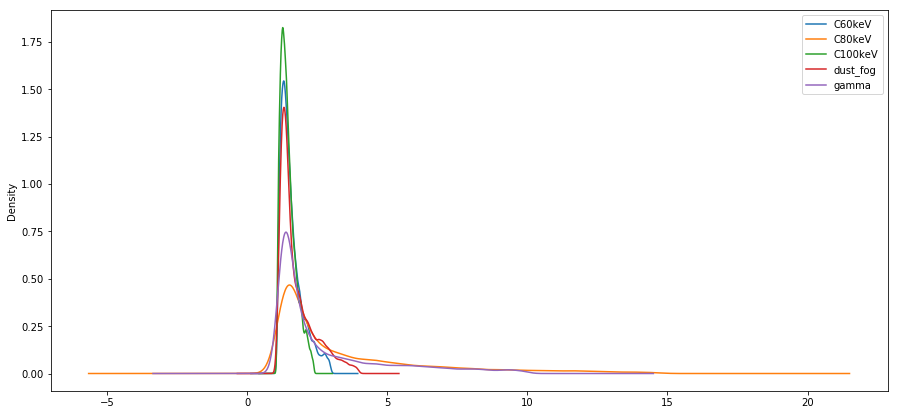

In [46]:
features_clean['eps'].plot.kde(stacked=True, figsize=(15,7))

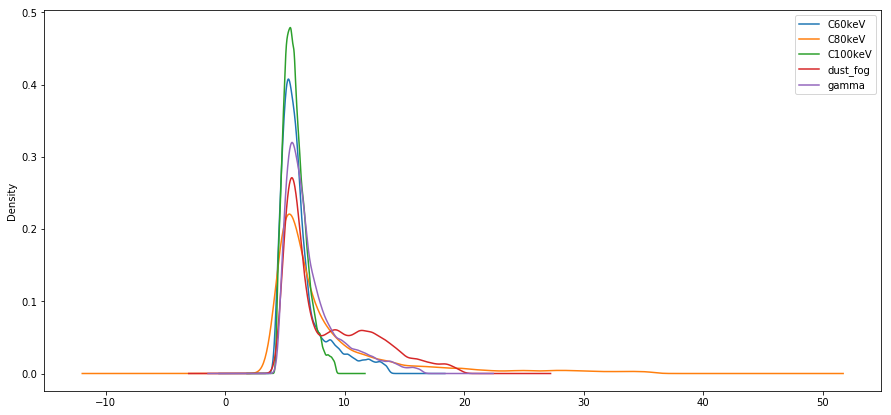

In [47]:
features_clean['minor_ax'].plot.kde(stacked=True, figsize=(15,7))

# TESTING ZONE

##### <font color='red'> RANDOM CODE HAPPENS </font>

Wall time: 2min 20s


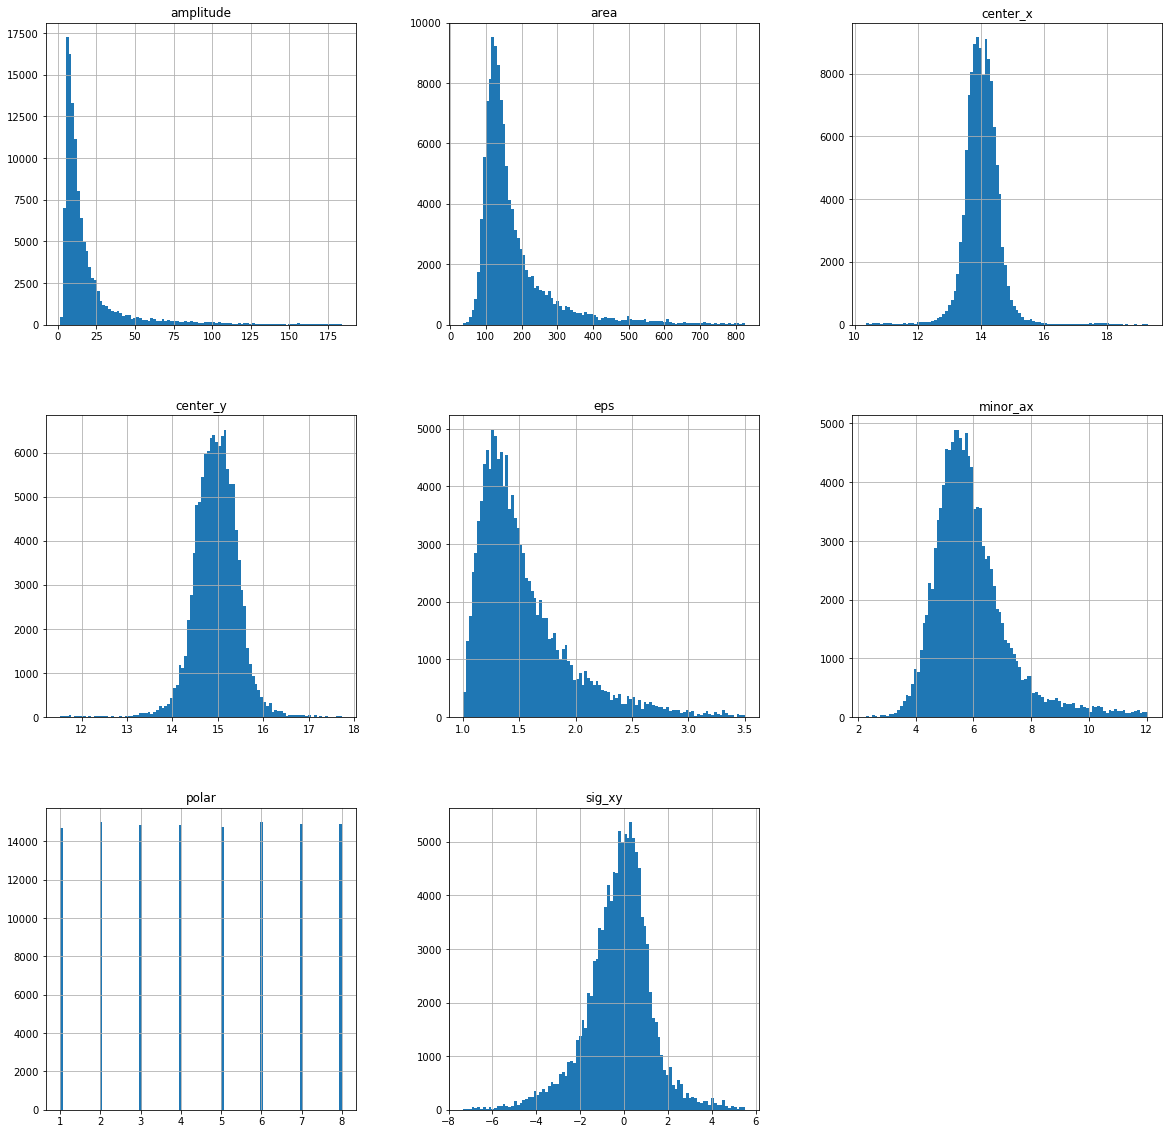

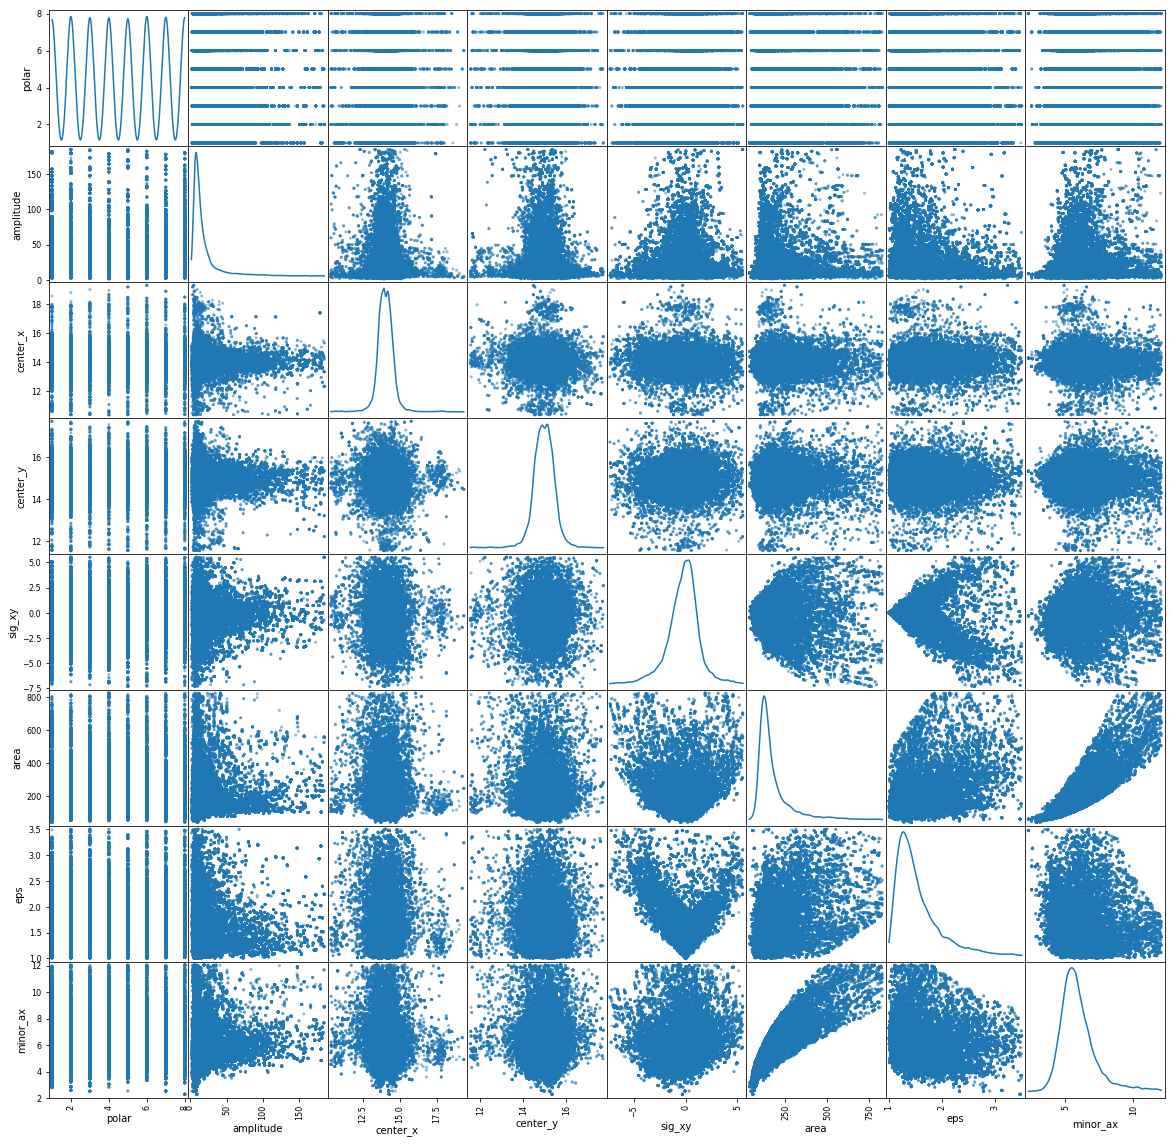

In [17]:
%%time
clean_giant_feat['C100keV'] = clean_quantile_feat(feat_giant_data['C100keV'], quant)
(clean_giant_feat['C100keV']).hist(bins=100, figsize=(20,20))
pd.plotting.scatter_matrix(clean_giant_feat['C100keV'], figsize=(20,20), diagonal='kde')

Wall time: 2min 17s


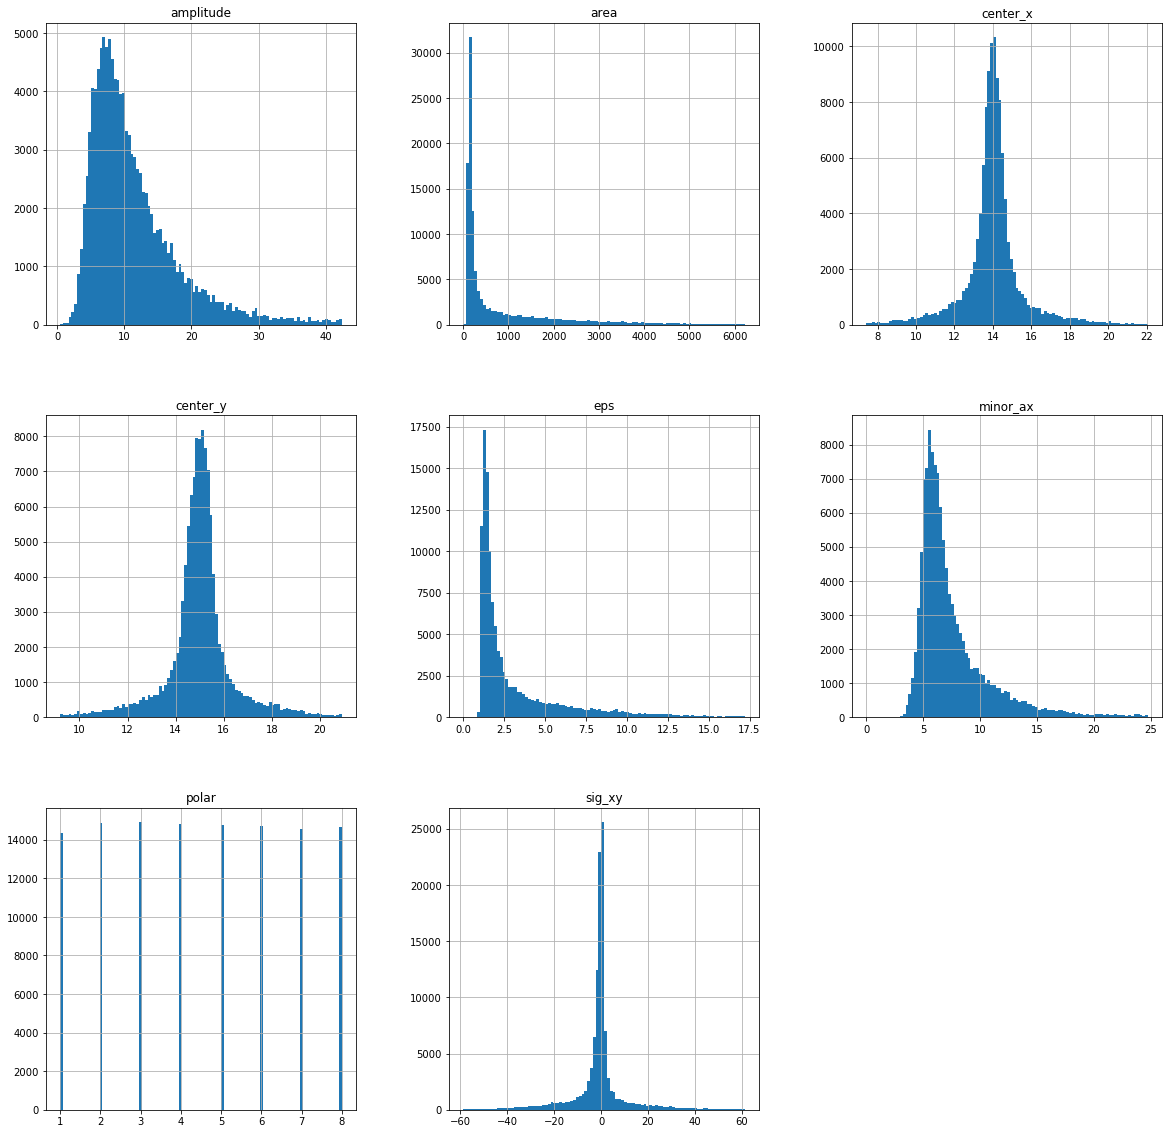

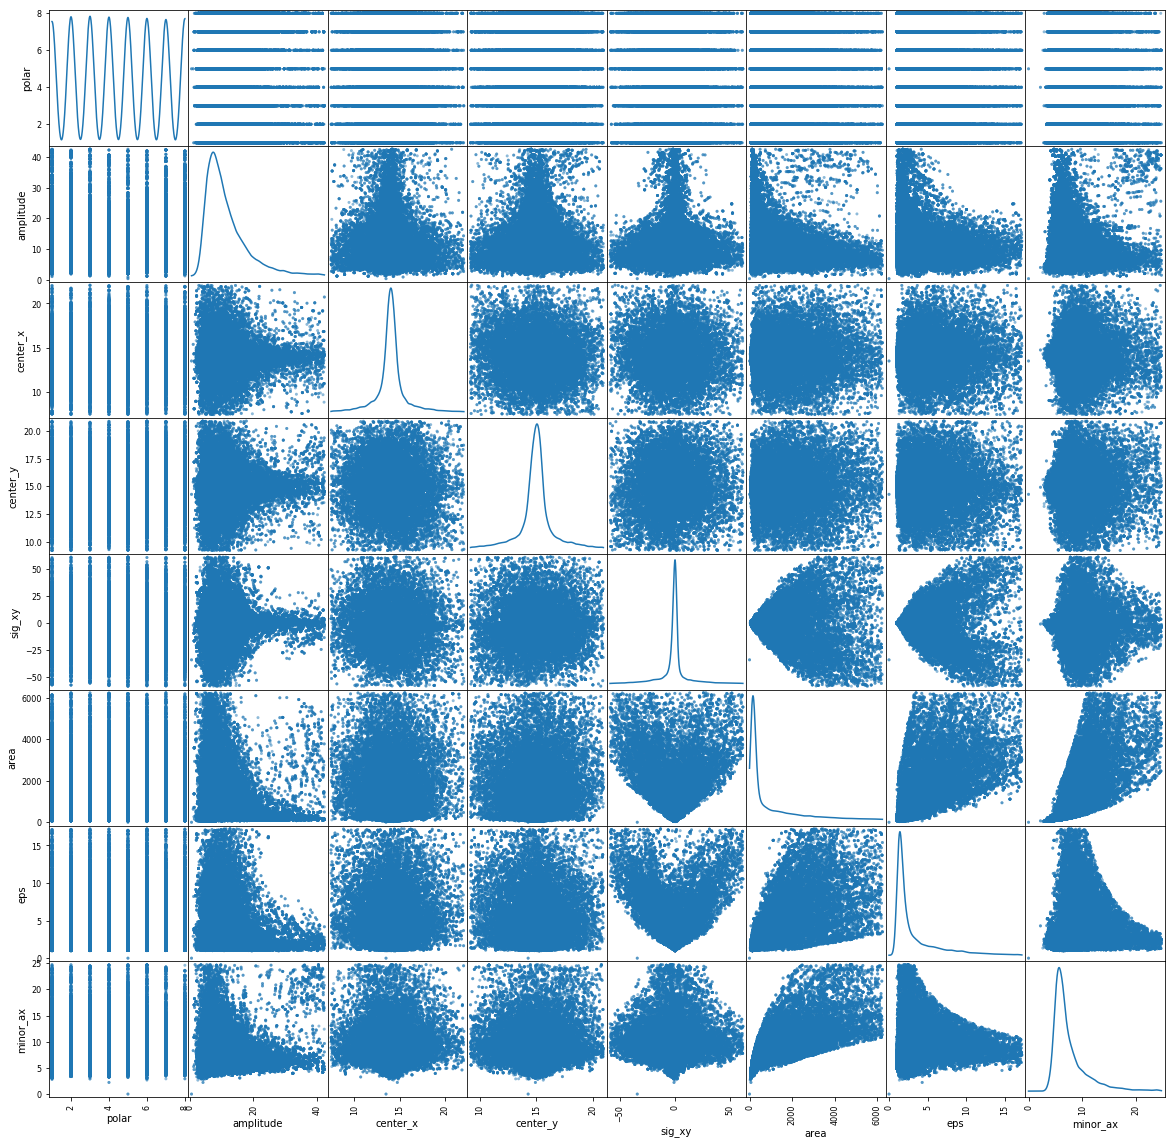

In [18]:
%%time
clean_giant_feat['gamma'] = clean_quantile_feat(feat_giant_data['gamma'], quant)
(clean_giant_feat['gamma']).hist(bins=100, figsize=(20,20))
pd.plotting.scatter_matrix(clean_giant_feat['gamma'], figsize=(20,20), diagonal='kde')

Wall time: 2min 2s


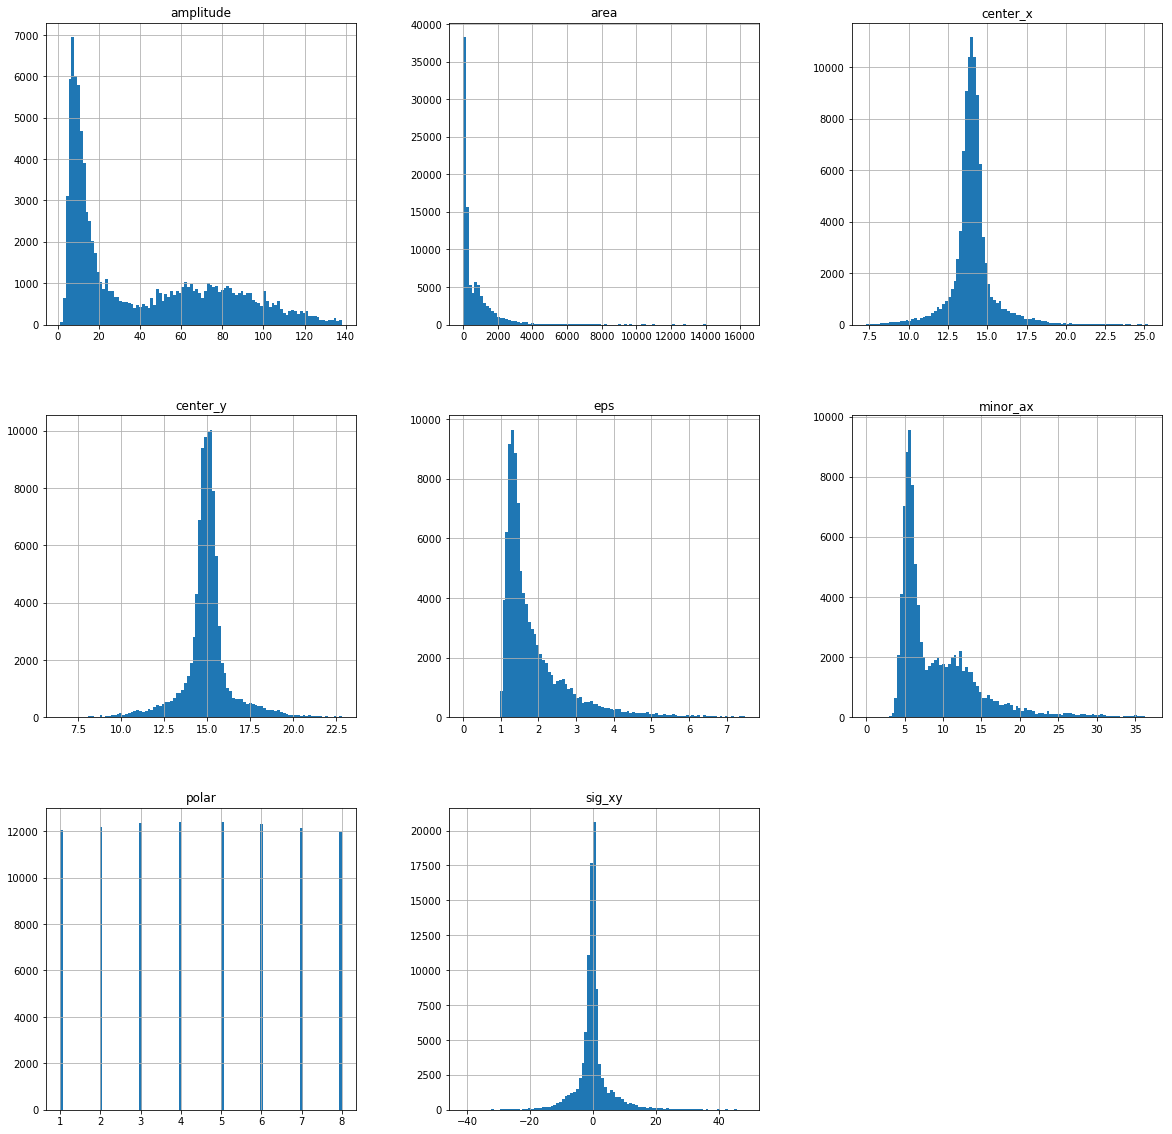

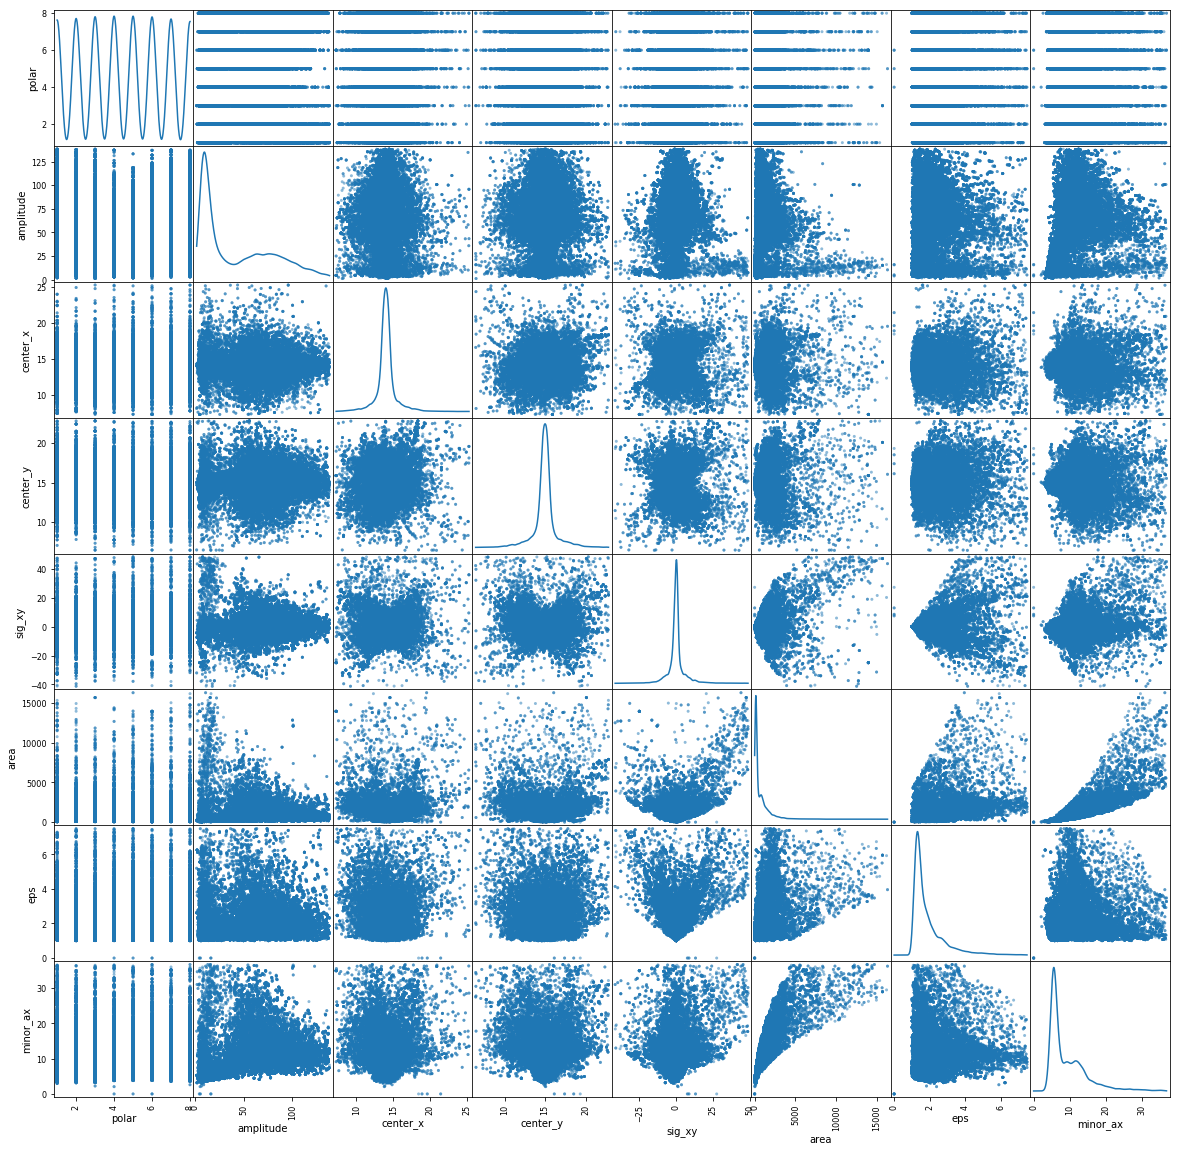

In [19]:
%%time
clean_giant_feat['dust_fog'] = clean_quantile_feat(feat_giant_data['dust_fog'], quant)
(clean_giant_feat['dust_fog']).hist(bins=100, figsize=(20,20))
pd.plotting.scatter_matrix(clean_giant_feat['dust_fog'], figsize=(20,20), diagonal='kde')

In [48]:
copa = 'artem'
copa[:3]

'art'